In [130]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

#### Question 1

In [87]:
r=0.05
sigma=0.25
S0=50
T=1
X=30
m=20
x=2.5

In [93]:
def stock_price_path(S0, T, r, sigma, steps, precision):
    S = np.zeros((steps + 1, precision))
    S[0] = S0
    dt = T/steps;
    
    for i in range(1, steps+1):
        w = np.random.standard_normal(size=precision)  # the Wiener process
        S[i] = S[i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * w)
    return S;

def amean(S0, T, r, sigma, steps, precision):
    dt = T/steps
    Sdt = stock_price_path(S0, T, r, sigma, steps, precision) * dt
    A_T = np.sum(Sdt, axis=0)
    return A_T/T

def gmean(S0, T, r, sigma, steps, precision):
    dt = T/steps
    Sdt = np.log(stock_price_path(S0, T, r, sigma, steps, precision)) * dt
    G_T = np.sum(Sdt, axis=0)
    return np.exp(G_T/T)

def arith_asian_call(S0, K, T, r, sigma, steps=1000, precision=1000):
    A_T = amean(S0, T, r, sigma, steps, precision)
    calls = [(max(a-K, 0) * np.exp(-r*T)) for a in A_T]
    return np.mean(calls)

def geom_asian_call(S0, K, T, r, sigma, steps=1000, precision=1000):
    G_T = gmean(S0, T, r, sigma, steps, precision)
    calls = [(max(g-K, 0) * np.exp(-r*T)) for g in G_T]
    return np.mean(calls)

def amean_gmean_call(S0, K, T, r, sigma, steps=1000, precision=1000):
    A_T = amean(S0, T, r, sigma, steps, precision)
    G_T = gmean(S0, T, r, sigma, steps, precision)
    calls = []
    for i in range(len(A_T)):
        a = A_T[i]
        g = G_T[i]
        calls.append(a-g)
    return np.mean(calls)

In [95]:
df = pd.DataFrame(columns=["Strike", "AC price", "GC price", "AC-GC", "A/G price"])
df["Strike"] = [X+i*x for i in range(m)]
ac_prices = [arith_asian_call(S0, strike, T, r, sigma, 1000, 10000) for strike in df["Strike"]]
gc_prices = [geom_asian_call(S0, strike, T, r, sigma, 1000, 10000) for strike in df["Strike"]]
agc_prices = [amean_gmean_call(S0, strike, T, r, sigma, 1000, 10000) for strike in df["Strike"]]
df["AC price"] = ac_prices
df["GC price"] = gc_prices
df["AC-GC"] = df["AC price"] - df["GC price"]
df["A/G price"] = agc_prices
df

,Strike,AC price,GC price,AC-GC,A/G price
0,30.0,20.249573,20.258587,-0.009014,0.168987
1,32.5,17.900042,17.981510,-0.081468,0.203831
2,35.0,15.515606,15.426364,0.089241,0.054313
3,37.5,13.150060,13.035956,0.114104,0.104551
4,40.0,10.859687,10.727787,0.131900,0.267773
5,42.5,8.578851,8.539357,0.039494,0.090195
6,45.0,6.685563,6.677025,0.008539,0.124450
7,47.5,4.946273,4.783212,0.163061,0.198847
8,50.0,3.420930,3.436882,-0.015952,0.113390
9,52.5,2.318921,2.208071,0.110850,0.036724


#### Question 2

In [26]:
V0 = 20000 
L0 = 22000
mu = -0.1
sigma = 0.2 
gamma = -0.4 
lambda1 = 0.2 
T = 5 
r0 = 0.02 
delta = 0.25 
lambda2 = 0.4 
alpha = 0.7 
recovery = 0.95

In [109]:
# Utility functions for call option valuation
def calc_APR(r0, delta, lambda2):
    return r0 + delta*lambda2
def calc_outstanding_loan(a,b,c,t):
    return a - b * c**(12*t)
def calc_optimal_exercise_boundary(alpha,beta,t):
    return alpha + beta*t
def calc_beta(recovery, alpha, T):
    return (recovery - alpha)/T
def calc_r_eff(R):
    return R/12
def calc_time_in_months(T):
    return T*12
def calc_PMT(L0, r, n):
    return (L0 * r)/(1 - 1/(1+r)**n)
def calc_a(PMT, r):
    return PMT/r
def calc_b(PMT, r, n):
    return PMT/(r * (1+r)**n)
def calc_c(r):
    return 1 + r
def calc_Q(Vt, qt, Lt):
    # Find the indices where the violation occurs for each row
    condition = Vt > (qt * Lt)
    first_events = np.argmax(condition, axis=1)
    max_int = np.iinfo(np.int32).max
    first_events[first_events == 0] = max_int
    return first_events
def calc_S(lambda2, t, N):
    dt = np.diff(t)[0]
    # Generate 2D Poisson process for all simulations at once
    N_t = poisson.rvs(lambda2 * dt, size=(N, len(t)))
    event_occurrences = (N_t > 0).argmax(axis=1) 
    # Set event time to infinity for simulations where no event occurred
    max_int = np.iinfo(np.int32).max
    event_occurrences[event_occurrences == 0] = max_int
    return event_occurrences
def simulate_jump_diffusion(T, dt, V0, mu, sigma, gamma, lambda1, N):
    # Initialize the time grid and the value process V
    t = np.arange(0, T, dt)
    V = np.zeros((N, len(t)))
    V[:, 0] = V0
    # Generate Brownian motion increments
    dWt = np.sqrt(dt) * np.random.normal(size=(N, len(t)-1))
    # Generate Poisson process increments
    dJt = poisson.rvs(lambda1 * dt, size=(N, len(t)-1))
    # Loop through time and apply the jump-diffusion process equation
    for i in range(1, len(t)):
        dVt_over_Vt_minus = mu * dt + sigma * dWt[:, i-1] + gamma * dJt[:, i-1]
        V[:, i] = V[:, i-1] * np.exp(dVt_over_Vt_minus)

    return t, V

In [110]:
def calc_option_value(dt, V0, L0, mu, sigma, gamma, lambda1, T, r0, delta, lambda2, alpha, recovery, N):
   
    # Simulate jump-diffusion process for collateral
    t, V = simulate_jump_diffusion(T, dt, V0, mu, sigma, gamma, lambda1, N)
    
    # Calculate APR
    APR = calc_APR(r0, delta, lambda2)
    
    # Calculate effective interest rate
    r = calc_r_eff(APR)
    
    # Calculate the time to maturity in months
    n = calc_time_in_months(T)
    
    # Calculate loan payment amount
    PMT = calc_PMT(L0, r, n)
    
    # Calculate parameters a, b, c for outstanding loan calculation
    a = calc_a(PMT, r)
    b = calc_b(PMT, r, n)
    c = calc_c(r)
       
    # Calculate outstanding loan amount at each time step
    Lt = calc_outstanding_loan(a, b, c, t)
    
    # Calculate qt at each time step
    beta = calc_beta(recovery, alpha, T)
    qt = calc_optimal_exercise_boundary(alpha, beta, t)
    
    # Calculate the first time when the collateral value violates the condition
    Q = calc_Q(V, qt, Lt)
    
    # Calculate the first time when an adverse event occurs
    S = calc_S(lambda2, t, N)
    
    # The option is exercised at the minimum of Q and S
    tau = np.minimum(Q, S)
    
    option_values = []
    
    for i in range(N):
        payoff = 0
        
        # If no exercise occurs, the option value is zero
        if tau[i] > T:
            payoff = 0
        # If tau is Q payoff is given by pending loan amount net of collateral recovery 
        elif tau[i] == Q[i]:
            payoff = max(Lt[Q[i]] - recovery*V[i][Q[i]], 0)
        # If tau is S payoff is given by absolute differce between pending loan amount and collateral recovery
        elif tau[i] == S[i]:
            payoff = abs(Lt[S[i]] - recovery*V[i][S[i]])
        
        # Discount the payoff back to the present
        option_value = (1 + r0/12) ** (-12 * tau[i]) * payoff
        option_values.append(option_value)
    
    # Calculate default times, considering only those where default occurred
    default_times = np.minimum(Q, S)
    default_occurred = default_times < T

    # Calculate default probability
    default_prob = np.mean(default_occurred)

    # Calculate expected exercise time
    expected_exercise_time = np.mean(default_times[default_occurred])
    
    return np.mean(option_values), default_prob, expected_exercise_time

### For $ \lambda_1 = 0.2 \space \space \space \lambda_2 = 0.4 \space \space \space T=5 $ 

In [113]:
option, prob, exercise_time = calc_option_value(0.01, V0, L0, mu, sigma, gamma, lambda1, T, r0, delta, lambda2, alpha, recovery, 100000)
print(f"Option Value: {option}")
print(f"Probablity of default: {prob}")
print(f"Expected Option Exercise time: {exercise_time}")

Option Value: 54.75903441031755
Probablity of default: 0.01559
Expected Option Exercise time: 2.499679281590763


In [115]:
def Proj6_2func(lambda1, lambda2, T):
    V0 = 20000 
    L0 = 22000
    mu = -0.1
    sigma = 0.2 
    gamma = -0.4 
    r0 = 0.02 
    delta = 0.25  
    alpha = 0.7 
    recovery = 0.95
    return calc_option_value(0.01, V0, L0, mu, sigma, gamma, lambda1, T, r0, delta, lambda2, alpha, recovery, 1000)

### For $ \lambda_1 = 0.2 \space \space \space \lambda_2 = [0.1, 0.8] \space \space \space T=[3,8] $ 

In [121]:
T = [i for i in range(3,8+1)]
lambda2_itr = 0.1
lambda1 = 0.2
T_itr = 3
data = []

while T_itr <= 8:
    lambda2_itr = 0.1
    while lambda2_itr <= 0.8:
        option, prob, exercise_time = calc_option_value(0.01, V0, L0, mu, sigma, gamma, lambda1, T_itr, r0, delta, lambda2_itr, alpha, recovery, 1000)
        tuple_elem = (lambda2_itr, T_itr, option, prob, exercise_time)
        data.append(tuple_elem)
        lambda2_itr = lambda2_itr + 0.1
    T_itr = T_itr+1

# Dataframe where lambda1 is constant
df1 = pd.DataFrame(data, columns=["Lambda2","T", "Option Value", "Probablity of Default", "Expected Exercise Time"])
df1

,Lambda2,T,Option Value,Probablity of Default,Expected Exercise Time
0,0.1,3,11.739792,0.003,1.333333
1,0.2,3,13.094392,0.004,1.250000
2,0.3,3,22.054972,0.006,1.166667
3,0.4,3,39.358081,0.012,1.416667
4,0.5,3,29.840262,0.009,1.444444
5,0.6,3,48.179344,0.011,1.272727
6,0.7,3,59.488783,0.015,1.200000
7,0.8,3,96.300708,0.020,1.450000
8,0.1,4,7.748929,0.002,1.500000
9,0.2,4,18.128613,0.007,2.571429


### For $ \lambda_2 = 0.4 \space \space \space \lambda_1 = 0.05 \space to \space 0.4 \space \space \space T=[3,8] $ 

In [140]:
T = [i for i in range(3,8+1)]
lambda2 = 0.4
lambda1_itr = 0.05
T_itr = 3
data = []

while T_itr <= 8:
    lambda1_itr = 0.05
    while lambda1_itr <= 0.4:
        option, prob, exercise_time = calc_option_value(0.01, V0, L0, mu, sigma, gamma, lambda1_itr, T_itr, r0, delta, lambda2, alpha, recovery, 1000)
        tuple_elem = (lambda1_itr, T_itr, option, prob, exercise_time)
        data.append(tuple_elem)
        lambda1_itr = lambda1_itr + 0.05
    T_itr = T_itr+1

# Dataframe where lambda1 is constant
df2 = pd.DataFrame(data, columns=["Lambda1","T", "Option Value", "Probablity of Default", "Expected Exercise Time"])
df2

,Lambda1,T,Option Value,Probablity of Default,Expected Exercise Time
0,0.05,3,37.247868,0.008,1.750000
1,0.10,3,35.004426,0.008,1.375000
2,0.15,3,51.391022,0.012,1.500000
3,0.20,3,35.828061,0.007,1.571429
4,0.25,3,51.578006,0.016,1.312500
5,0.30,3,36.964688,0.009,1.444444
6,0.35,3,33.995748,0.009,1.333333
7,0.40,3,30.818984,0.009,1.777778
8,0.05,4,39.376149,0.011,2.090909
9,0.10,4,66.950577,0.018,1.722222


In [128]:
groups1 = df1.groupby("Lambda2")
groups2 = df2.groupby("Lambda1")

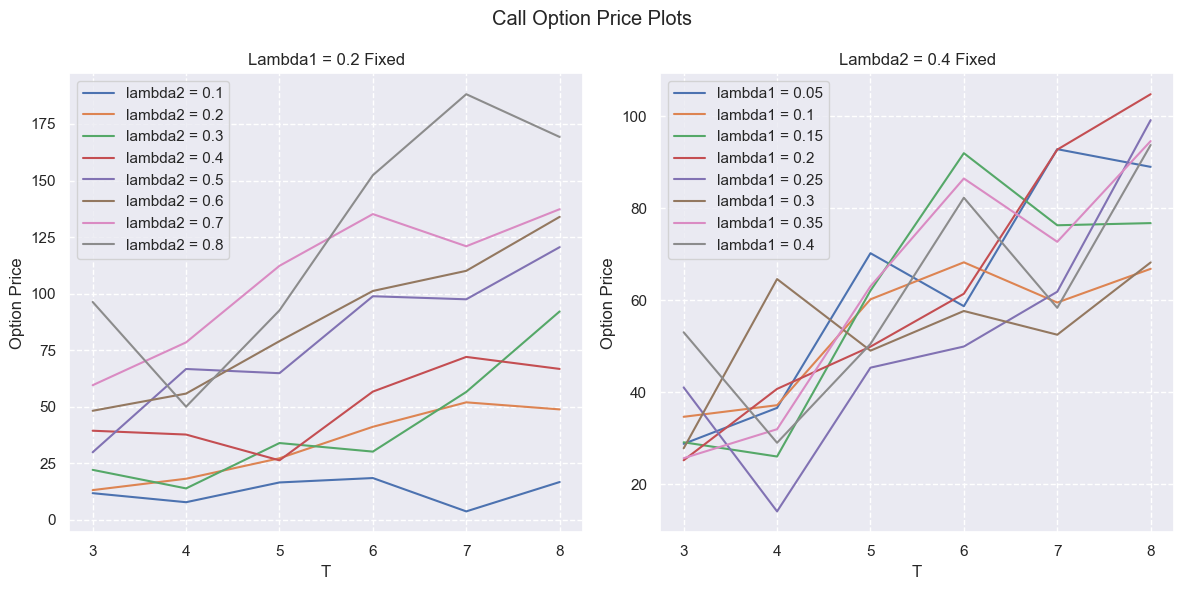

In [137]:
# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Set dashed grid lines
for ax in axes:
    ax.grid(True, linestyle='dashed')

for name, group in groups1:
    axes[0].plot(group["T"], group["Option Value"], label=f"lambda2 = {round(name, 2)}")
    axes[0].set_xlabel('T')
    axes[0].set_ylabel('Option Price')
    axes[0].set_title('Lambda1 = 0.2 Fixed')
axes[0].legend()

for name, group in groups2:
    axes[1].plot(group["T"], group["Option Value"], label=f"lambda1 = {round(name, 2)}")
    axes[1].set_xlabel('T')
    axes[1].set_ylabel('Option Price')
    axes[1].set_title('Lambda2 = 0.4 Fixed')
axes[1].legend()
    
# Set title to the entire plot
plt.suptitle('Call Option Price Plots')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot

plt.show()

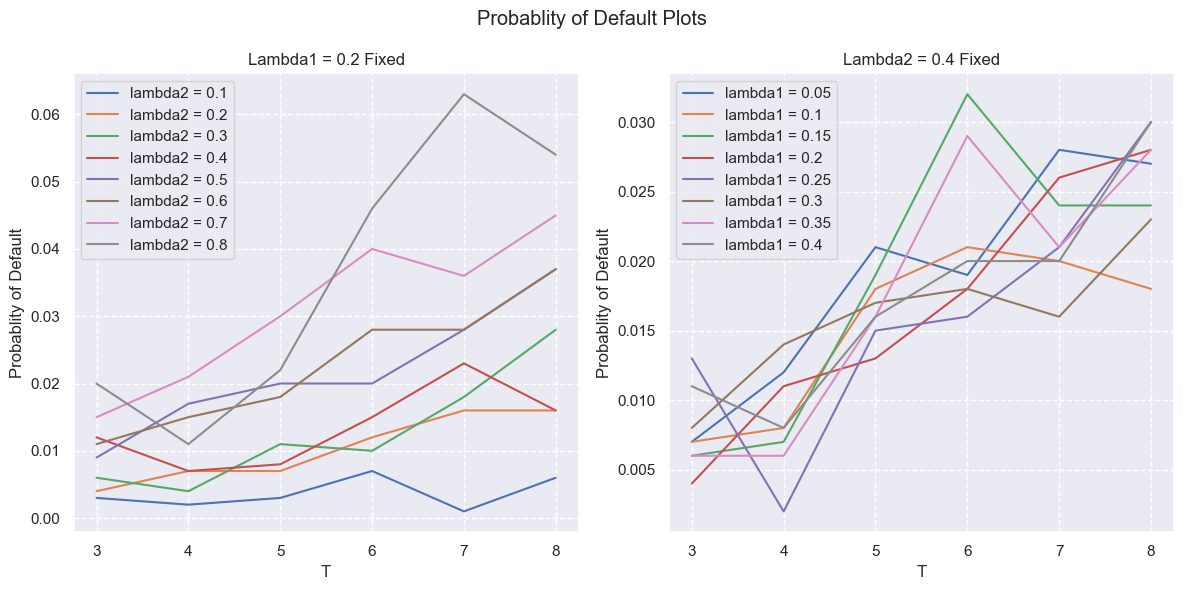

In [138]:
# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Set dashed grid lines
for ax in axes:
    ax.grid(True, linestyle='dashed')

for name, group in groups1:
    axes[0].plot(group["T"], group["Probablity of Default"], label=f"lambda2 = {round(name, 2)}")
    axes[0].set_xlabel('T')
    axes[0].set_ylabel('Probablity of Default')
    axes[0].set_title('Lambda1 = 0.2 Fixed')
axes[0].legend()

for name, group in groups2:
    axes[1].plot(group["T"], group["Probablity of Default"], label=f"lambda1 = {round(name, 2)}")
    axes[1].set_xlabel('T')
    axes[1].set_ylabel('Probablity of Default')
    axes[1].set_title('Lambda2 = 0.4 Fixed')
axes[1].legend()
    
# Set title to the entire plot
plt.suptitle('Probablity of Default Plots')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

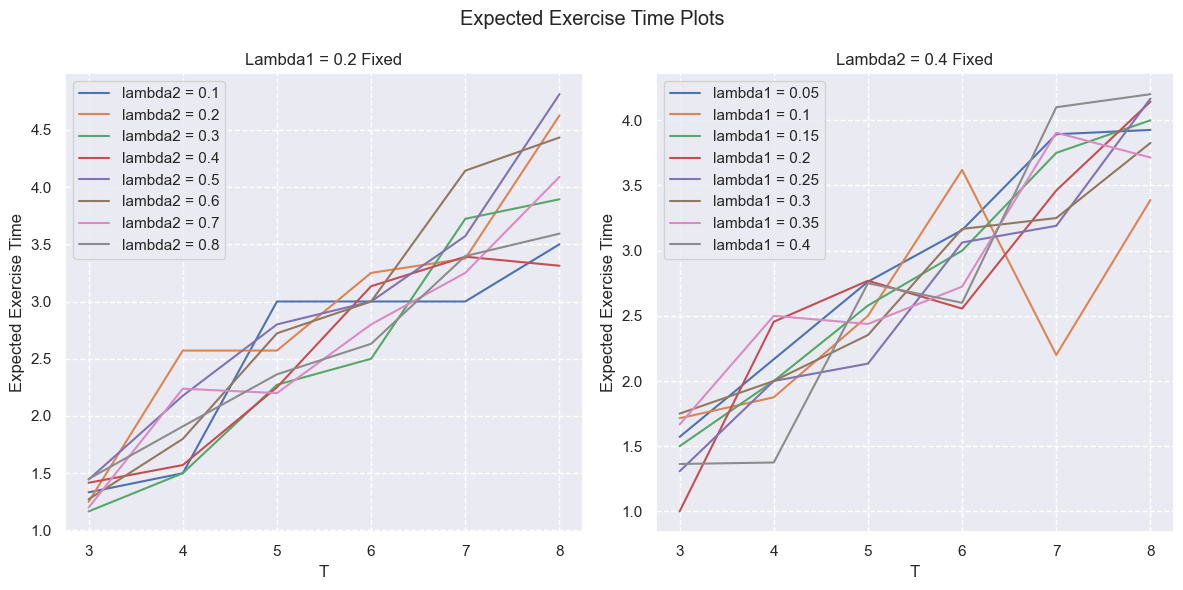

In [139]:
# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Set dashed grid lines
for ax in axes:
    ax.grid(True, linestyle='dashed')

for name, group in groups1:
    axes[0].plot(group["T"], group["Expected Exercise Time"], label=f"lambda2 = {round(name, 2)}")
    axes[0].set_xlabel('T')
    axes[0].set_ylabel('Expected Exercise Time')
    axes[0].set_title('Lambda1 = 0.2 Fixed')
axes[0].legend()

for name, group in groups2:
    axes[1].plot(group["T"], group["Expected Exercise Time"], label=f"lambda1 = {round(name, 2)}")
    axes[1].set_xlabel('T')
    axes[1].set_ylabel('Expected Exercise Time')
    axes[1].set_title('Lambda2 = 0.4 Fixed')
axes[1].legend()
    
# Set title to the entire plot
plt.suptitle('Expected Exercise Time Plots')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()